Here, I'll show the relationship between cartoframes and geopandas.

In [1]:
import cartoframes as cf
import geopandas as gpd
%matplotlib inline

In [2]:
cxn = cf.CartoContext() # remember, store your credentials 
                        # using cf.credentials.set_credentials!

I have an example dataset in my CARTO account which contains some data on criminology from 1960 onwards at the county level. I'll load that now using the standard read function from cartoframes:

In [3]:
df = cxn.read('nat')

Now, by default, CARTO uses the typical Well-known-binary (WKB) serialization for geometries that come out of PostGIS. 

In [4]:
df.head(2)[['fipsno', 'the_geom']]

,fipsno,the_geom
cartodb_id,,
1505,17165.0,0103000020E6100000010000000700000000000000661A...
1720,40053.0,0103000020E61000000100000007000000000000205F86...


With [PR#86](https://github.com/CartoDB/cartoframes/pull/86), these strings are now deserialized into `shapely` objects! This means a dataframe from `cartoframes` is almost directly mapped to `Geopandas` dataframes. 

In [5]:
df.head(2)[['fipsno', 'geometry']]

,fipsno,geometry
cartodb_id,,
1505,17165.0,"POLYGON ((-88.4124755859375 37.60790252685547,..."
1720,40053.0,"POLYGON ((-98.09955596923828 36.59130859375, -..."


This allows you to do GIS operations locally in Geopandas. To send a dataframe with shapely geometries into a Geopandas dataframe, you only need to call the constructor directly on the dataframe:

In [6]:
gdf = gpd.GeoDataFrame(df)

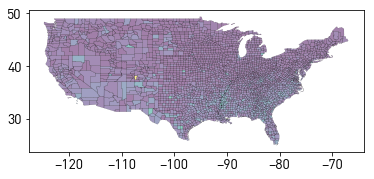

In [7]:
gpd.GeoDataFrame(df).plot('hr90', linewidth=.1) #to prove we're in geopandas

The nice thing with having the code to serialize/deserialize `shapely` objects is that you can publish directly to CARTO (and make CARTO maps) directly from (geo)pandas:

In [8]:
cxn.write(df, encode_geom=True, table_name='new_table', overwrite=True)

If you change the geometries locally, the changes propagate back to CARTO:

In [9]:
gdf['geometry'] = gdf.geometry.apply(lambda x: x.buffer(2))
df['geometry'] = df.geometry.apply(lambda x: x.buffer(2))

In [10]:
cxn.write(gdf, encode_geom=True, table_name='buffered', overwrite=True)

In [11]:
gdf.head()

,ma90,south,fp89,dnl60,mfil79,rd90,dv80,hc60,po70,ps90,...,blk90,rd60,state_fips,dv90,fp69,field_1,fipsno,fh90,pol80,geometry
cartodb_id,,,,,,,,,,,,,,,,,,,,,
1505,38.2,0.0,15.828502,4.226510,9.695417,0.377041,5.412968,1.000000,25721.0,0.207842,...,3.506459,0.457671,17.0,8.403532,19.3,1504.0,17165.0,13.172442,10.255833,POLYGON ((-88.35277784856117 35.60879368035607...
1720,39.5,1.0,11.474435,2.089815,9.738908,-0.342290,4.069299,0.000000,7117.0,-1.178859,...,0.052733,-0.358385,40.0,5.862884,14.6,1719.0,40053.0,7.134364,8.782323,POLYGON ((-98.09408038595517 34.59131608926712...
2799,36.7,1.0,9.645150,3.555298,9.842463,-0.553942,4.230542,0.666667,24165.0,0.554042,...,0.854684,-0.498175,48.0,7.072922,13.0,2798.0,48091.0,9.104427,10.503587,"POLYGON ((-99.342072998125 27.87317430656412, ..."
14,43.9,0.0,8.383961,1.454312,9.708567,-0.737595,3.135889,0.000000,4564.0,-1.724842,...,0.034495,-0.173043,38.0,5.452946,14.6,13.0,38023.0,9.113001,8.158802,POLYGON ((-100.9549124845266 49.24699589679899...
68,35.5,0.0,10.930828,2.602347,9.551587,-0.652795,2.569074,0.000000,5388.0,-1.070270,...,0.000000,-0.089455,27.0,5.014409,21.2,67.0,27125.0,6.746371,8.607217,"POLYGON ((-98.481259264152 48.00606406878377, ..."


In [12]:
cxn.map(layers=[cf.BaseMap(), cf.Layer('buffered', 
                                       color=dict(column='gi69'))],
        interactive=True)